In [2]:
import geopandas as gdp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re

# Preparación de datasets

En este notebook realizamos el prepocesamiento de los reportes extraidos de REDATAM. Dado que la plataforma exporta los datos en archivos Excel con formatos no estructurados, aca transformamos esa información en csv's listos para integrarse al análisis.

### 1 Datos del Censo 2022 

####  1.1 Bases Cartográficas de Radios Censales

In [3]:
# Cargamos los datos espaciales
gdf = gdp.read_file("../data/external/radios/radios2022_v1.0.shp")

In [4]:
# Este GeoDataFrame tiene información geoespacial de los radios censales y demas atributos
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 66502 entries, 0 to 66501
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   NOMPROV   66502 non-null  object  
 1   PROV      66502 non-null  object  
 2   NOMDEPTO  66502 non-null  object  
 3   DEPTO     66502 non-null  object  
 4   FRAC      66502 non-null  object  
 5   RADIO     66502 non-null  object  
 6   TIPO      66487 non-null  object  
 7   LINK      66502 non-null  object  
 8   OBS2020   19 non-null     object  
 9   geometry  66502 non-null  geometry
dtypes: geometry(1), object(9)
memory usage: 5.1+ MB


Aca limitamos a los datos del DEPARTAMENTO Rosario

In [5]:
rosario = gdf[gdf["NOMDEPTO"] == "Rosario"]

In [6]:
# Vemos los valores unicos de las las variables
print("NOMPROV",rosario['NOMPROV'].unique())
print("PROV",rosario['PROV'].unique())
print("NOMDEPTO",rosario['NOMDEPTO'].unique())
print("DEPTO",rosario['DEPTO'].unique())
print("FRAC",rosario['FRAC'].unique())
print("RADIO",rosario['RADIO'].unique())
print("TIPO",rosario['TIPO'].unique())
print("LINK",rosario['LINK'].unique())
print("OBS2020",rosario['OBS2020'].unique())
#print("geometry",rosario['geometry'].unique())

NOMPROV ['SANTA FE']
PROV ['82']
NOMDEPTO ['Rosario']
DEPTO ['084']
FRAC ['02' '03' '20' '21' '06' '07' '31' '32' '49' '50' '63' '01' '04' '05'
 '08' '09' '10' '11' '12' '13' '14' '15' '16' '17' '18' '19' '22' '23'
 '24' '25' '26' '27' '28' '29' '30' '33' '34' '35' '36' '37' '38' '39'
 '40' '41' '42' '64' '43' '44' '45' '46' '47' '48' '51' '52' '53' '54'
 '55' '56' '57' '58' '59' '60' '61' '62' '65' '66' '67' '68' '69' '70'
 '71' '72' '73' '74' '75' '76' '77' '78' '79' '80' '81' '82' '83' '84'
 '85' '86' '87' '88' '89' '90' '95']
RADIO ['16' '18' '21' '22' '01' '02' '03' '04' '05' '06' '07' '08' '09' '10'
 '11' '12' '13' '14' '15' '17' '19' '20' '23' '24' '25' '26' '27' '28'
 '29' '30' '31' '32' '33' '34' '35' '36' '37' '38' '39' '40' '41' '42'
 '43' '44' '45' '46']
TIPO ['U' 'M' 'R']
LINK ['820840216' '820840218' '820840221' ... '820840220' '820840219'
 '820848814']
OBS2020 [None]


 Agregamos dos nuevas variables que representan los códigos de las 'Fracciones' y de los 'Radios Censales'    

Aca estariamos reconstruyendo las variables necesarias para posteriormente fusionar estos datos espaciales con los datos censales.

In [7]:
# Variables de identificación geográfica de Fraccion Censal
gdf['CodigoFraccion'] = (
    gdf['PROV'].astype(str).str.zfill(2) +
    gdf['DEPTO'].astype(str).str.zfill(3) +
    gdf['FRAC'].astype(str).str.zfill(2) 
)

# Variables de identificación geográfica de Radio Censal
gdf['CodigoRadioCensal'] = (
    gdf['PROV'].astype(str).str.zfill(2) +
    gdf['DEPTO'].astype(str).str.zfill(3) +
    gdf['FRAC'].astype(str).str.zfill(2) +
    gdf['RADIO'].astype(str).str.zfill(2)
)

In [8]:
gdf[['CodigoFraccion','CodigoRadioCensal']].head(5)

,CodigoFraccion,CodigoRadioCensal
0,0200701,020070101
1,0200702,020070210
2,0200709,020070909
3,0202819,020281906
4,0202819,020281907


Estos datos de las fracciones censales fueron brindados por la **Dirección de Estadistica**, previo a un trabajo manual de seleccion de dichas fracciones para identificar cuales corresponden con la ciudad de Rosario.

In [9]:
# Aca tomamos los Codigos de los Fracciones Censales de Rosario. 
with open("../data/external/fracciones_censales_rosario.txt", "r", encoding="utf-8") as f:
    lineas = f.readlines()

# Extraemos los códigos numéricos de cada línea (fracciones censales)
codigos_ciudad_rosario = [re.search(r"\d+", linea).group() for linea in lineas if re.search(r"\d+", linea)]

print(codigos_ciudad_rosario)

['8208403', '8208404', '8208405', '8208406', '8208407', '8208408', '8208409', '8208410', '8208411', '8208412', '8208413', '8208414', '8208415', '8208416', '8208417', '8208418', '8208419', '8208420', '8208421', '8208422', '8208423', '8208424', '8208425', '8208426', '8208427', '8208428', '8208429', '8208430', '8208431', '8208432', '8208433', '8208434', '8208435', '8208436', '8208437', '8208438', '8208439', '8208440', '8208441', '8208442', '8208443', '8208444', '8208445', '8208446', '8208447', '8208448', '8208449', '8208450', '8208451', '8208452', '8208453', '8208454', '8208455', '8208456', '8208480', '8208481', '8208482', '8208483', '8208484', '8208485', '8208486', '8208487']


In [10]:
# Filtramos el GeoDataFrame
gdf_rosario_filtrado = gdf[gdf['CodigoFraccion'].isin(codigos_ciudad_rosario)]
gdf_rosario_filtrado.head()

,NOMPROV,PROV,NOMDEPTO,DEPTO,FRAC,RADIO,TIPO,LINK,OBS2020,geometry,CodigoFraccion,CodigoRadioCensal
57892,SANTA FE,82,Rosario,084,03,01,U,820840301,None,"POLYGON ((-60.74758 -32.89534, -60.75633 -32.8...",8208403,820840301
57893,SANTA FE,82,Rosario,084,03,02,U,820840302,None,"POLYGON ((-60.73798 -32.87591, -60.73794 -32.8...",8208403,820840302
57894,SANTA FE,82,Rosario,084,03,03,U,820840303,None,"POLYGON ((-60.72183 -32.88329, -60.7218 -32.88...",8208403,820840303
57895,SANTA FE,82,Rosario,084,03,04,U,820840304,None,"POLYGON ((-60.73305 -32.88559, -60.73543 -32.8...",8208403,820840304
57896,SANTA FE,82,Rosario,084,03,05,U,820840305,None,"POLYGON ((-60.71966 -32.88779, -60.71972 -32.8...",8208403,820840305


Vemos entonces que en Rosario hay 1537 radios censales totales.

In [11]:
gdf_rosario_filtrado.info() #1537 radios censales en la ciudad de Rosario

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 1537 entries, 57892 to 61986
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   NOMPROV            1537 non-null   object  
 1   PROV               1537 non-null   object  
 2   NOMDEPTO           1537 non-null   object  
 3   DEPTO              1537 non-null   object  
 4   FRAC               1537 non-null   object  
 5   RADIO              1537 non-null   object  
 6   TIPO               1537 non-null   object  
 7   LINK               1537 non-null   object  
 8   OBS2020            0 non-null      object  
 9   geometry           1537 non-null   geometry
 10  CodigoFraccion     1537 non-null   object  
 11  CodigoRadioCensal  1537 non-null   object  
dtypes: geometry(1), object(11)
memory usage: 156.1+ KB


Text(0.5, 1.0, 'Radios Censales de la Ciudad de Rosario')

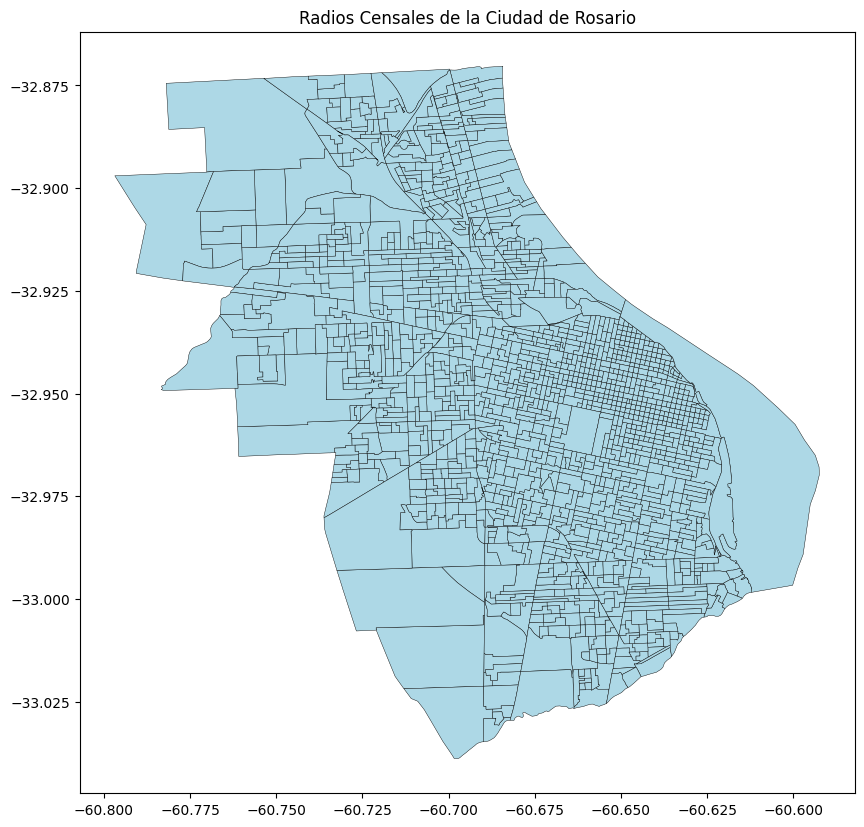

In [12]:
# Graficamos los radios censales de la ciudad de Rosario
gdf_rosario_filtrado.plot(figsize=(10, 10), color='lightblue', edgecolor='black', linewidth=0.3)
plt.title("Radios Censales de la Ciudad de Rosario")

#### 1.2 Datos del Censo Nacional de Población, Hogares y Viviendas 2022

Estos datos fueron extraidos del [Portal Redatam](https://redatam.indec.gob.ar/binarg/RpWebEngine.exe/Portal?BASE=CPV2022&lang=ESP), seleccionamos la base de datos de __viviendas particulares__ y los siguientes indicadores:
- Necesidates Básicas Insatisfecha (__NBI__) 
- Indice de Privación Materiales de los Hogares (__IPMH__)



In [13]:
# Leemos los datos censales recolectados del portal REDATAM
datos_censales = pd.read_csv("../data/raw/datos_censales_redatam.csv")

In [14]:
datos_censales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1537 entries, 0 to 1536
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype
---  ------                            --------------  -----
 0   CodigoRadioCensal                 1537 non-null   int64
 1   NBI_Hacinamiento_Si               1537 non-null   int64
 2   NBI_Hacinamiento_No               1537 non-null   int64
 3   NBI_Vivienda_Si                   1537 non-null   int64
 4   NBI_Vivienda_No                   1537 non-null   int64
 5   NBI_Sanitarias_Si                 1537 non-null   int64
 6   NBI_Sanitarias_No                 1537 non-null   int64
 7   NBI_Escolaridad_Si                1537 non-null   int64
 8   NBI_Escolaridad_No                1537 non-null   int64
 9   NBI_Subsistencia_Si               1537 non-null   int64
 10  NBI_Subsistencia_No               1537 non-null   int64
 11  NBI_Si                            1537 non-null   int64
 12  NBI_No                            

In [15]:
datos_censales.head(10)

,CodigoRadioCensal,NBI_Hacinamiento_Si,NBI_Hacinamiento_No,NBI_Vivienda_Si,NBI_Vivienda_No,NBI_Sanitarias_Si,NBI_Sanitarias_No,NBI_Escolaridad_Si,NBI_Escolaridad_No,NBI_Subsistencia_Si,NBI_Subsistencia_No,NBI_Si,NBI_No,Sin_IPMH,IPMH_Solo_Recursos_Corrientes,IPMH_Solo_Recursos_Patrimoniales,IPMH_Convergente,Total Hogares
0,820840301,28,239,14,253,7,260,3,264,5,262,52,215,35,15,117,100,267
1,820840302,2,283,1,284,0,285,1,284,1,284,5,280,167,37,56,25,285
2,820840303,9,231,6,234,1,239,0,240,2,238,16,224,135,58,25,22,240
3,820840304,10,429,6,433,5,434,3,436,3,436,23,416,271,62,59,47,439
4,820840305,4,239,3,240,2,241,4,239,0,243,13,230,147,42,35,19,243
5,820840306,8,343,5,346,3,348,1,350,3,348,18,333,203,68,45,35,351
6,820840307,0,201,0,201,0,201,1,200,0,201,1,200,175,20,4,2,201
7,820840308,8,222,6,224,8,222,2,228,2,228,24,206,122,24,33,51,230
8,820840309,2,205,1,206,0,207,0,207,0,207,3,204,138,42,12,15,207
9,820840310,17,215,4,228,1,231,4,228,2,230,26,206,70,53,55,54,232


In [16]:
# Ver cuántos NaN hay en cada columna
print("NaN por columna:")
print(datos_censales.isnull().sum())

NaN por columna:
CodigoRadioCensal                   0
NBI_Hacinamiento_Si                 0
NBI_Hacinamiento_No                 0
NBI_Vivienda_Si                     0
NBI_Vivienda_No                     0
NBI_Sanitarias_Si                   0
NBI_Sanitarias_No                   0
NBI_Escolaridad_Si                  0
NBI_Escolaridad_No                  0
NBI_Subsistencia_Si                 0
NBI_Subsistencia_No                 0
NBI_Si                              0
NBI_No                              0
Sin_IPMH                            0
IPMH_Solo_Recursos_Corrientes       0
IPMH_Solo_Recursos_Patrimoniales    0
IPMH_Convergente                    0
Total Hogares                       0
dtype: int64


In [17]:
# Chequeamos los codigos antes del merge
print("Códigos en gdf_rosario_filtrado (primeros 5):")
print(gdf_rosario_filtrado['CodigoRadioCensal'].head().tolist())

print("\nCódigos en datos_censales (primeros 5):")
print(datos_censales['CodigoRadioCensal'].head().tolist())

Códigos en gdf_rosario_filtrado (primeros 5):
['820840301', '820840302', '820840303', '820840304', '820840305']

Códigos en datos_censales (primeros 5):
[820840301, 820840302, 820840303, 820840304, 820840305]


In [18]:
# Convertimos ambas columnas 'CodigoRadioCensal' a tipo string para evitar problemas en el merge
gdf_rosario_filtrado['CodigoRadioCensal'] = gdf_rosario_filtrado['CodigoRadioCensal'].astype(str)
datos_censales['CodigoRadioCensal'] = datos_censales['CodigoRadioCensal'].astype(str)

/home/santiago/anaconda3/lib/python3.11/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [19]:
# Hacemos el merge por CodigoRadioCensal
datos_censales_con_gdf = gdf_rosario_filtrado.merge(datos_censales, on='CodigoRadioCensal', how='left')

In [20]:
datos_censales_con_gdf.columns

Index(['NOMPROV', 'PROV', 'NOMDEPTO', 'DEPTO', 'FRAC', 'RADIO', 'TIPO', 'LINK',
       'OBS2020', 'geometry', 'CodigoFraccion', 'CodigoRadioCensal',
       'NBI_Hacinamiento_Si', 'NBI_Hacinamiento_No', 'NBI_Vivienda_Si',
       'NBI_Vivienda_No', 'NBI_Sanitarias_Si', 'NBI_Sanitarias_No',
       'NBI_Escolaridad_Si', 'NBI_Escolaridad_No', 'NBI_Subsistencia_Si',
       'NBI_Subsistencia_No', 'NBI_Si', 'NBI_No', 'Sin_IPMH',
       'IPMH_Solo_Recursos_Corrientes', 'IPMH_Solo_Recursos_Patrimoniales',
       'IPMH_Convergente', 'Total Hogares'],
      dtype='object')

In [21]:
# Guardamos los datos censales con gdf para no tener que ejecutar todo de nuevo cada vez
# datos_censales_con_gdf.to_file("../data/processed/datos_censales_con_gdf.gpkg", driver='GPKG')

Nos quedo colgada la columna 'PoblacionTotal'. La agregamos ahora

In [22]:
poblacion_total = pd.read_csv("../data/raw/poblacion_radios_censales_rosario.csv", header=0)

In [23]:
poblacion_total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1537 entries, 0 to 1536
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   CodigoRadioCensal  1537 non-null   int64
 1   Total_Poblacion    1537 non-null   int64
dtypes: int64(2)
memory usage: 24.1 KB


In [24]:
#Antes del merge, convertimos a string la columna CodigoRadioCensal
poblacion_total['CodigoRadioCensal'] = poblacion_total['CodigoRadioCensal'].astype(str)
datos_censales_con_gdf['CodigoRadioCensal'] = datos_censales_con_gdf['CodigoRadioCensal'].astype(str)

#Merge de los datos censales con la población total
datos_censales_con_gdf = datos_censales_con_gdf.merge(poblacion_total[['CodigoRadioCensal', 'Total_Poblacion']], on='CodigoRadioCensal', how='left')

In [25]:
datos_censales_con_gdf.columns

Index(['NOMPROV', 'PROV', 'NOMDEPTO', 'DEPTO', 'FRAC', 'RADIO', 'TIPO', 'LINK',
       'OBS2020', 'geometry', 'CodigoFraccion', 'CodigoRadioCensal',
       'NBI_Hacinamiento_Si', 'NBI_Hacinamiento_No', 'NBI_Vivienda_Si',
       'NBI_Vivienda_No', 'NBI_Sanitarias_Si', 'NBI_Sanitarias_No',
       'NBI_Escolaridad_Si', 'NBI_Escolaridad_No', 'NBI_Subsistencia_Si',
       'NBI_Subsistencia_No', 'NBI_Si', 'NBI_No', 'Sin_IPMH',
       'IPMH_Solo_Recursos_Corrientes', 'IPMH_Solo_Recursos_Patrimoniales',
       'IPMH_Convergente', 'Total Hogares', 'Total_Poblacion'],
      dtype='object')

In [36]:
# Renombramos la columna Total Hogares
datos_censales_con_gdf = datos_censales_con_gdf.rename(columns={"Total Hogares": "Total_Hogares"})

In [26]:
# Guardamos los datos censales con gdf en un nuevo csv para no tener que ejecutar todo de nuevo cada vez
# datos_censales_con_gdf.to_file("../data/processed/datos_censales_con_gdf.gpkg", driver='GPKG')

In [37]:
datos_censales_con_gdf.columns

Index(['NOMPROV', 'PROV', 'NOMDEPTO', 'DEPTO', 'FRAC', 'RADIO', 'TIPO', 'LINK',
       'OBS2020', 'geometry', 'CodigoFraccion', 'CodigoRadioCensal',
       'NBI_Hacinamiento_Si', 'NBI_Hacinamiento_No', 'NBI_Vivienda_Si',
       'NBI_Vivienda_No', 'NBI_Sanitarias_Si', 'NBI_Sanitarias_No',
       'NBI_Escolaridad_Si', 'NBI_Escolaridad_No', 'NBI_Subsistencia_Si',
       'NBI_Subsistencia_No', 'NBI_Si', 'NBI_No', 'Sin_IPMH',
       'IPMH_Solo_Recursos_Corrientes', 'IPMH_Solo_Recursos_Patrimoniales',
       'IPMH_Convergente', 'Total_Hogares', 'Total_Poblacion'],
      dtype='object')

In [28]:
# Vemos el total de poblacion en la ciudad de Rosario
datos_censales_con_gdf['Total_Poblacion'].sum()  # Debería ser 1,300,069 según los datos de la Municipalidad de Rosario

1030069

> Seleccionamos correctamente los radios censales de la ciudad de Rosario

Esto lo podemos verificar facilmente, ya que la población (1.300.069 habitantes) coincide con los datos publicados en la  [página de la Municipalidad de Rosario](https://datos.rosario.gob.ar/poblacion/datos-censales/censo-2022-0).

In [38]:
# Guardamos los datos censales con gdf 
datos_censales_con_gdf.to_file("../data/processed/datos_censales_con_gdf.gpkg", driver='GPKG')

-----

In [ ]:
#datos_censales_con_gdf = gdp.read_file("../data/processed/datos_censales_con_gdf.gpkg")

### 2 Datos del cruce de 'Tipo de vivienda particular ocupada' por 'Cantidad de hogares'

Ahora vamos a procesar la salida obtenida en REDATAM para los cruces de "Tipo de Vivienda Ocupada" con "Total de Hogares"

Esta informacion fue extraida en la seccion *Viviendas particulares | Cruces | Múltiple*

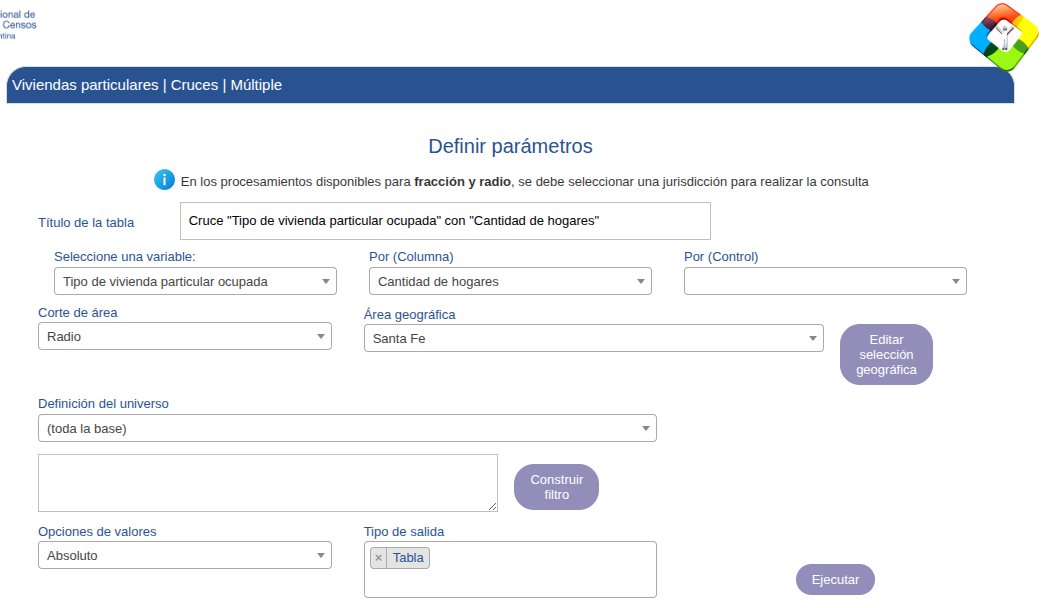

In [47]:
# Leemos la salida del excel que descargamos de REDATAM
datos_redatam = pd.read_excel("../../cruce_tipo_vivienda_total_hogares.xlsX")

Definimos una función para extraer datos del excel, ignorando encabezados, totales y demas

In [40]:
def procesar_redatam_CRUCE_vivienda_hogares(ruta_archivo):
    # Leemos el archivo sin encabezados
    df_raw = pd.read_excel(ruta_archivo, header=None)
    
    datos_procesados = []
    
    # Ubicamos los nombres de los tipos de vivienda
    tipos_vivienda = [
        'Casa A', 'Casa B', 'Rancho', 'Casilla', 'Departamento',
        'Pieza ocupada en inquilinato, hotel familiar o pensión',
        'Local no construido para habitación ocupado',
        'Vivienda móvil ocupada (casa rodante, barco, carpa u otra)'
    ]
    
    radio_actual = None
    data_actual = {tipo: 0 for tipo in tipos_vivienda}
    data_actual['CodigoRadioCensal'] = None

    def limpiar_num(valor):
        if pd.isna(valor) or str(valor).strip() in ['-', '']:
            return 0
        try:
            return int(valor)
        except:
            return 0

    # Ahora iteramos fila por fila
    for index, row in df_raw.iterrows():
        celda_0 = str(row[0])

        # Si encontramos la palabra "RESUMEN" en la primera columna, significa que terminaron los datos relevantes.
        if "RESUMEN" in celda_0:
            break 
        
        # Detectamos inicio de los datos (Radio Censal)
        # Esto ignora el encabeazado del principio
        if "AREA #" in celda_0:
            if radio_actual is not None:
                datos_procesados.append(data_actual.copy())
            
            # Expresión regular para extraer el número del radio censal
            match = re.search(r'(\d+)', celda_0)
            if match:
                radio_actual = int(match.group(1))
                data_actual = {tipo: 0 for tipo in tipos_vivienda}
                data_actual['CodigoRadioCensal'] = radio_actual
        
        # Procesamos filas de datos
        elif any(tipo in celda_0 for tipo in tipos_vivienda) and radio_actual is not None:
            tipo_encontrado = next((t for t in tipos_vivienda if t == celda_0.strip()), None)
            
            if tipo_encontrado:
                total_hogares_calculado = 0
                
                # Mapa de columnas (incluyendo la corrección del 10)
                mapa_multiplicadores = {
                    1: 1, 2: 2, 3: 3, 4: 4, 
                    5: 5, 6: 6, 7: 7, 8: 10
                }
                
                for indice_col, multiplicador in mapa_multiplicadores.items():
                    if indice_col < len(row):
                        cantidad_viviendas = limpiar_num(row[indice_col])
                        total_hogares_calculado += cantidad_viviendas * multiplicador
                
                data_actual[tipo_encontrado] = total_hogares_calculado

    # Guardamos el último radio antes del break o final
    if radio_actual is not None:
        datos_procesados.append(data_actual)

    # Creamos el DataFrame y ordenamos
    df_final = pd.DataFrame(datos_procesados)
    cols = ['CodigoRadioCensal'] + tipos_vivienda
    df_final = df_final[cols]
    
    return df_final

In [51]:
# --- Ejecutamos la funcion ---
df_cruce_vivienda_hogar = procesar_redatam_CRUCE_vivienda_hogares("../data/raw/cruce_tipo_vivienda_total_hogares.xlsX")

In [52]:
df_cruce_vivienda_hogar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1537 entries, 0 to 1536
Data columns (total 9 columns):
 #   Column                                                      Non-Null Count  Dtype
---  ------                                                      --------------  -----
 0   CodigoRadioCensal                                           1537 non-null   int64
 1   Casa A                                                      1537 non-null   int64
 2   Casa B                                                      1537 non-null   int64
 3   Rancho                                                      1537 non-null   int64
 4   Casilla                                                     1537 non-null   int64
 5   Departamento                                                1537 non-null   int64
 6   Pieza ocupada en inquilinato, hotel familiar o pensión      1537 non-null   int64
 7   Local no construido para habitación ocupado                 1537 non-null   int64
 8   Vivienda móvil ocup

Logramos extraer los datos del excel (1537 radios censales)

Este df nos dice la cantidad de hogares de X tipo de vivienda en cada CodigoRadioCensal

In [53]:
# Agregamos columna "Total_Hogares" al dataframe de cruces
df_cruce_vivienda_hogar['Total_Hogares'] = df_cruce_vivienda_hogar.drop(columns=['CodigoRadioCensal']).sum(axis=1)

df_cruce_vivienda_hogar.head()

,CodigoRadioCensal,Casa A,Casa B,Rancho,Casilla,Departamento,"Pieza ocupada en inquilinato, hotel familiar o pensión",Local no construido para habitación ocupado,"Vivienda móvil ocupada (casa rodante, barco, carpa u otra)",Total_Hogares
0,820840301,90,141,20,9,2,3,1,1,267
1,820840302,274,3,0,0,7,1,0,0,285
2,820840303,204,21,2,3,7,2,0,1,240
3,820840304,379,40,0,5,14,1,0,0,439
4,820840305,201,26,3,2,10,1,0,0,243


Contrastamos la información que tenemos en el dataset de cruces y el dataset original con el que venimos trabajando.

In [62]:
# Total de hogares en 'datos_censales_con_gdf'
total_hogares_original = datos_censales_con_gdf['Total_Hogares'].sum()
print(f"Total de hogares en datos_censales_con_gdf: {total_hogares_original}")

# Total de hogares en 'df_cruce_vivienda_hogar'
total_hogares_cruce = df_cruce_vivienda_hogar['Total_Hogares'].sum()
print(f"Total de hogares en df_cruce_vivienda_hogar: {total_hogares_cruce}")

Total de hogares en datos_censales_con_gdf: 402085
Total de hogares en df_cruce_vivienda_hogar: 402085


In [66]:
datos_censales_con_gdf.columns

Index(['NOMPROV', 'PROV', 'NOMDEPTO', 'DEPTO', 'FRAC', 'RADIO', 'TIPO', 'LINK',
       'OBS2020', 'CodigoFraccion', 'CodigoRadioCensal', 'NBI_Hacinamiento_Si',
       'NBI_Hacinamiento_No', 'NBI_Vivienda_Si', 'NBI_Vivienda_No',
       'NBI_Sanitarias_Si', 'NBI_Sanitarias_No', 'NBI_Escolaridad_Si',
       'NBI_Escolaridad_No', 'NBI_Subsistencia_Si', 'NBI_Subsistencia_No',
       'NBI_Si', 'NBI_No', 'Sin_IPMH', 'IPMH_Solo_Recursos_Corrientes',
       'IPMH_Solo_Recursos_Patrimoniales', 'IPMH_Convergente', 'Total_Hogares',
       'Total_Poblacion', 'geometry'],
      dtype='object')

In [65]:
df_cruce_vivienda_hogar.columns

Index(['CodigoRadioCensal', 'Casa A', 'Casa B', 'Rancho', 'Casilla',
       'Departamento',
       'Pieza ocupada en inquilinato, hotel familiar o pensión',
       'Local no construido para habitación ocupado',
       'Vivienda móvil ocupada (casa rodante, barco, carpa u otra)',
       'Total_Hogares'],
      dtype='object')

In [67]:
# Convertimos a un mismo tipo de dato antes del merge
df_cruce_vivienda_hogar['CodigoRadioCensal'] = df_cruce_vivienda_hogar['CodigoRadioCensal'].astype('str')
datos_censales_con_gdf['CodigoRadioCensal'] = datos_censales_con_gdf['CodigoRadioCensal'].astype('str')

# Comparamos si en cada radio censal los totales de hogares coinciden 
comparacion_hogares = pd.merge(
    datos_censales_con_gdf[['CodigoRadioCensal', 'Total_Hogares']],
    df_cruce_vivienda_hogar[['CodigoRadioCensal', 'Total_Hogares']],
    on='CodigoRadioCensal',
    suffixes=('_original', '_cruce')
)
comparacion_hogares['Coincide'] = comparacion_hogares['Total_Hogares_original'] == comparacion_hogares['Total_Hogares_cruce']

comparacion_hogares.head()

,CodigoRadioCensal,Total_Hogares_original,Total_Hogares_cruce,Coincide
0,820840301,267,267,True
1,820840302,285,285,True
2,820840303,240,240,True
3,820840304,439,439,True
4,820840305,243,243,True


In [70]:
# Vemos si hay discrepancias entre los totales de hogares
discrepancias = comparacion_hogares[~comparacion_hogares['Coincide']]
print(f"Número de radios censales con discrepancias: {len(discrepancias)}")

Número de radios censales con discrepancias: 0


Entonces los datos extraidos del cruce coinciden con los datos originales.

In [72]:
df_cruce_vivienda_hogar.columns

Index(['CodigoRadioCensal', 'Casa A', 'Casa B', 'Rancho', 'Casilla',
       'Departamento',
       'Pieza ocupada en inquilinato, hotel familiar o pensión',
       'Local no construido para habitación ocupado',
       'Vivienda móvil ocupada (casa rodante, barco, carpa u otra)',
       'Total_Hogares'],
      dtype='object')

In [73]:
# Renombramos las varibles antes de guardarlas
df_cruce_vivienda_hogar = df_cruce_vivienda_hogar.rename(columns={
    "Casa A": "hogares_en_casa_a",
    "Casa B": "hogares_en_casa_b",
    "Rancho": "hogares_en_rancho",
    "Casilla": "hogares_en_casilla",
    "Departamento": "hogares_en_departamento",
    "Pieza ocupada en inquilinato, hotel familiar o pensión": "hogares_en_pieza_inquilinato",
    "Local no construido para habitación ocupado": "hogares_en_local_no_hab",
    "Vivienda móvil ocupada (casa rodante, barco, carpa u otra)": "hogares_en_vivienda_movil",
})

In [74]:
# Guardamos el dataframe procesado
df_cruce_vivienda_hogar.to_csv("../data/processed/cruce_tipo_vivienda_total_hogares.csv", index=False)

----------------------------------------------
Realizamos el merge con los datos censales originales 

In [75]:
# Leemos los datos censales originales
datos_censales_con_gdf = gdp.read_file("../data/processed/datos_censales_con_gdf.gpkg")

In [76]:
# Dropeamos Total_Hogares para evitar confusiones en el merge
df_cruce_vivienda_hogar = df_cruce_vivienda_hogar.drop(columns=['Total_Hogares'])

In [77]:
# Hacemos merge con los nuevos datos de tipo de vivienda por radio censal
datos_censales_con_gdf = datos_censales_con_gdf.merge(
    df_cruce_vivienda_hogar,
    on='CodigoRadioCensal',
    how='left'
)

In [78]:
datos_censales_con_gdf.columns

Index(['NOMPROV', 'PROV', 'NOMDEPTO', 'DEPTO', 'FRAC', 'RADIO', 'TIPO', 'LINK',
       'OBS2020', 'CodigoFraccion', 'CodigoRadioCensal', 'NBI_Hacinamiento_Si',
       'NBI_Hacinamiento_No', 'NBI_Vivienda_Si', 'NBI_Vivienda_No',
       'NBI_Sanitarias_Si', 'NBI_Sanitarias_No', 'NBI_Escolaridad_Si',
       'NBI_Escolaridad_No', 'NBI_Subsistencia_Si', 'NBI_Subsistencia_No',
       'NBI_Si', 'NBI_No', 'Sin_IPMH', 'IPMH_Solo_Recursos_Corrientes',
       'IPMH_Solo_Recursos_Patrimoniales', 'IPMH_Convergente', 'Total_Hogares',
       'Total_Poblacion', 'geometry', 'hogares_en_casa_a', 'hogares_en_casa_b',
       'hogares_en_rancho', 'hogares_en_casilla', 'hogares_en_departamento',
       'hogares_en_pieza_inquilinato', 'hogares_en_local_no_hab',
       'hogares_en_vivienda_movil'],
      dtype='object')

In [79]:
# Vemos el total de hogares de la ciudad
total_hogares_ciudad = datos_censales_con_gdf['Total_Hogares'].sum()
print(f"Total de hogares en la ciudad después del merge: {total_hogares_ciudad}")

Total de hogares en la ciudad después del merge: 402085


Chequeamos si coincide el total de hogares con la suma de los totales de hogares de cada tipo de vivienda.

In [80]:
# Sumamos total de hogares por tipo de vivienda
total_hogares_por_tipo = {
    'hogares_en_casa_a': datos_censales_con_gdf['hogares_en_casa_a'].sum(),
    'hogares_en_casa_b': datos_censales_con_gdf['hogares_en_casa_b'].sum(),
    'hogares_en_rancho': datos_censales_con_gdf['hogares_en_rancho'].sum(),
    'hogares_en_casilla': datos_censales_con_gdf['hogares_en_casilla'].sum(),
    'hogares_en_departamento': datos_censales_con_gdf['hogares_en_departamento'].sum(),
    'hogares_en_pieza_inquilinato': datos_censales_con_gdf['hogares_en_pieza_inquilinato'].sum(),
    'hogares_en_local_no_hab': datos_censales_con_gdf['hogares_en_local_no_hab'].sum(),
    'hogares_en_vivienda_movil': datos_censales_con_gdf['hogares_en_vivienda_movil'].sum(),
}   

# Sumamos todos los hogares por tipo
total_hogares_calculado = sum(total_hogares_por_tipo.values())
print(f"Total de hogares calculado por tipo de vivienda: {total_hogares_calculado}")

# Imprimomos Total Hogares p ver si coincide 
print(f"Total de hogares original: {datos_censales_con_gdf['Total_Hogares'].sum()}")

Total de hogares calculado por tipo de vivienda: 402085
Total de hogares original: 402085


In [81]:
datos_censales_con_gdf.columns

Index(['NOMPROV', 'PROV', 'NOMDEPTO', 'DEPTO', 'FRAC', 'RADIO', 'TIPO', 'LINK',
       'OBS2020', 'CodigoFraccion', 'CodigoRadioCensal', 'NBI_Hacinamiento_Si',
       'NBI_Hacinamiento_No', 'NBI_Vivienda_Si', 'NBI_Vivienda_No',
       'NBI_Sanitarias_Si', 'NBI_Sanitarias_No', 'NBI_Escolaridad_Si',
       'NBI_Escolaridad_No', 'NBI_Subsistencia_Si', 'NBI_Subsistencia_No',
       'NBI_Si', 'NBI_No', 'Sin_IPMH', 'IPMH_Solo_Recursos_Corrientes',
       'IPMH_Solo_Recursos_Patrimoniales', 'IPMH_Convergente', 'Total_Hogares',
       'Total_Poblacion', 'geometry', 'hogares_en_casa_a', 'hogares_en_casa_b',
       'hogares_en_rancho', 'hogares_en_casilla', 'hogares_en_departamento',
       'hogares_en_pieza_inquilinato', 'hogares_en_local_no_hab',
       'hogares_en_vivienda_movil'],
      dtype='object')

In [ ]:
# Guardamos el GeoDataFrame que fuimos modificando en pasos anteriores
#datos_censales_con_gdf.to_file('../data/processed/datos_censales_con_gdf.gpkg', driver='GPKG')

----------------------------------------

## 3 Datos del ReNaBaP

--------------------------

## 4 Datos de 'Tipo de Vivienda Particular Ocupada'

-----

> Chequeamos si tenemos radios censales donde la cantidad de hogares es mayor a la cantidad de viviendas

Esto despues vemos donde ubicarlo, entiendo que debería estar en el EDA cuando tenemos los datasets cargados

In [88]:
datos_censales_con_gdf = gdp.read_file("../data/processed/datos_censales_con_gdf.gpkg")

In [89]:
# Vemos cantidad de hogares totales
total_hogares_ciudad = datos_censales_con_gdf['Total_Hogares'].sum()
print(f"Total de hogares en la ciudad: {total_hogares_ciudad}")

Total de hogares en la ciudad: 402085


In [92]:
# Vemos total de viviendas en la ciudad
total_viviendas_ciudad = datos_censales_con_gdf['total_viv'].sum()
print(f"Total de viviendas en la ciudad: {total_viviendas_ciudad}")

Total de viviendas en la ciudad: 396457


In [96]:
# Vemos si algun radio tiene mas hogares de viviendas que hogares
radios_con_mas_hogares_que_viviendas = datos_censales_con_gdf[
    datos_censales_con_gdf['total_viv'] > datos_censales_con_gdf['Total_Hogares']
]
print(f"Número de radios censales con más viviendas que hogares: {len(radios_con_mas_hogares_que_viviendas)}")

Número de radios censales con más viviendas que hogares: 0
